## Time Series dataset for prediction

### Crawl data NO2 using openeo

In [ ]:
import openeo

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

aoi = {
    "type": "Polygon",
    "coordinates": [
        [
            [
              112.84,
              -7.16
            ],
            [
              112.84,
              -7.17
            ],
            [
              112.85,
              -7.166
            ],
            [
              112.85,
              -7.16
            ],
            [
              112.84,
              -7.16
            ]
        ]
    ],
    "type": "Polygon"   
}

s5p_no2 = connection.load_collection(
    "SENTINEL_5P_L2",
    temporal_extent=["2023-10-15", "2025-10-19"],
    spatial_extent={
        "west": 112.84,
        "south": -7.17,
        "east": 112.86,
        "north": -7.15
    },
    bands=["NO2"]
)

# 4. Hitung rata-rata harian
s5p_no2_daily = s5p_no2.aggregate_temporal_period(
    period="day",
    reducer="mean"
)

# 5. Hitung rata-rata spasial berdasarkan AOI
s5p_no2_aoi = s5p_no2_daily.aggregate_spatial(
    geometries=aoi,
    reducer="mean"
)

job = s5p_no2.execute_batch(title="NO2 in Kwanyar", outputfile="NO2_in_Kwanyar.nc")

Authenticated using refresh token.
0:00:00 Job 'j-251020012218471885b5e15ea1d543a2': send 'start'
0:00:13 Job 'j-251020012218471885b5e15ea1d543a2': created (progress 0%)
0:00:18 Job 'j-251020012218471885b5e15ea1d543a2': created (progress 0%)
0:00:25 Job 'j-251020012218471885b5e15ea1d543a2': created (progress 0%)
0:00:33 Job 'j-251020012218471885b5e15ea1d543a2': created (progress 0%)
0:00:43 Job 'j-251020012218471885b5e15ea1d543a2': created (progress 0%)
0:00:56 Job 'j-251020012218471885b5e15ea1d543a2': finished (progress 100%)


### Read dataset

In [22]:
import netCDF4

file_path = "data/NO2_in_Kwanyar.nc"
ds = netCDF4.Dataset(file_path)

# Lihat seluruh variabel yang tersedia
print("📦 Variabel dalam file:")
print(ds.variables.keys())

# Misal variabel utama bernama "NO2"
no2 = ds.variables["NO2"][:]

# Waktu (biasanya dalam format 'days since ...' atau sejenis)
time = ds.variables["t"][:]

# Konversi waktu ke format tanggal jika punya atribut 'units'
try:
    time_units = ds.variables["t"].units
    dates = netCDF4.num2date(time, units=time_units)
except Exception:
    dates = time  # fallback kalau tidak ada units

# Tampilkan 10 baris pertama
print("\n📅 Contoh data pertama:")
for i in range(min(10, len(no2))):
    print(f"{dates[i]} | NO2: {no2[i]}")


📦 Variabel dalam file:
dict_keys(['t', 'x', 'y', 'crs', 'NO2'])

📅 Contoh data pertama:
2022-10-19 00:00:00 | NO2: [[--]]
2022-10-20 00:00:00 | NO2: [[--]]
2022-10-21 00:00:00 | NO2: [[--]]
2022-10-22 00:00:00 | NO2: [[4.196543522994034e-05]]
2022-10-23 00:00:00 | NO2: [[5.009567394154146e-05]]
2022-10-24 00:00:00 | NO2: [[--]]
2022-10-25 00:00:00 | NO2: [[2.2872925910633057e-05]]
2022-10-26 00:00:00 | NO2: [[--]]
2022-10-27 00:00:00 | NO2: [[--]]
2022-10-28 00:00:00 | NO2: [[3.214428579667583e-05]]


<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


### Transform data from NC to CSV

In [ ]:
import netCDF4
import pandas as pd
import numpy as np

# 1. Baca file NetCDF
file_path = "data/NO2_in_Kwanyar.nc"
ds = netCDF4.Dataset(file_path)

# 2. Tampilkan struktur file
print(ds)

# 3. Ambil variabel yang tersedia
print(ds.variables.keys())

# 4. Ambil variabel waktu dan NO2
time_var = ds.variables["t"][:]
no2_var = ds.variables["NO2"][:]

# 5. Konversi waktu ke datetime
time_units = ds.variables["t"].units
dates = netCDF4.num2date(time_var, units=time_units)

# 6. Jika data NO2 berdimensi lebih dari 1 (misalnya [time, lat, lon]),
# kita rata-ratakan agar menjadi satu nilai per waktu
if no2_var.ndim > 1:
    no2_mean = np.nanmean(no2_var, axis=tuple(range(1, no2_var.ndim)))
else:
    no2_mean = no2_var

# 7. Buat DataFrame
df = pd.DataFrame({
    "time": dates,
    "NO2": no2_mean
})

# 8. Simpan ke CSV
df.to_csv("data/NO2_Kwanyar.csv", index=False)
print("✅ File NO2_Kwanyar.csv berhasil dibuat.")
print(df.head())


<class 'netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.9
    institution: Copernicus Data Space Ecosystem openEO API - 0.68.0a10.dev20250930+2976
    description: 
    title: 
    dimensions(sizes): t(1090), y(1), x(1)
    variables(dimensions): int32 t(t), float64 x(x), float64 y(y), |S1 crs(), float32 NO2(t, y, x)
    groups: 
dict_keys(['t', 'x', 'y', 'crs', 'NO2'])
✅ File NO2_Kwanyar.csv berhasil dibuat.
                  time       NO2
0  2022-10-19 00:00:00       NaN
1  2022-10-20 00:00:00       NaN
2  2022-10-21 00:00:00       NaN
3  2022-10-22 00:00:00  0.000042
4  2022-10-23 00:00:00  0.000050


### Interpolation NaN value

In [7]:
import pandas as pd

df = pd.read_csv("data/NO2_Kwanyar.csv")

df['time'] = pd.to_datetime(df['time'], errors='coerce')

df = df.set_index('time')

df['NO2'] = df['NO2'].interpolate(method='time')

print(df.isna().sum())

n_lags = 4

supervised = pd.DataFrame()

for i in range(n_lags, 0, -1):
    supervised[f'NO2(t-{i})'] = df['NO2'].shift(i)

supervised['NO2(t)'] = df['NO2']

# drop NaN value
supervised = supervised.dropna()

print("📅 Head of Data:")
print(supervised.head())

print("")
print("📦 Data info:")
supervised.info

NO2    3
dtype: int64
📅 Head of Data:
            NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)    NO2(t)
time                                                        
2022-10-26  0.000042  0.000050  0.000036  0.000023  0.000026
2022-10-27  0.000050  0.000036  0.000023  0.000026  0.000029
2022-10-28  0.000036  0.000023  0.000026  0.000029  0.000032
2022-10-29  0.000023  0.000026  0.000029  0.000032  0.000030
2022-10-30  0.000026  0.000029  0.000032  0.000030  0.000028

📦 Data info:


<bound method DataFrame.info of             NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)    NO2(t)
time                                                        
2022-10-26  0.000042  0.000050  0.000036  0.000023  0.000026
2022-10-27  0.000050  0.000036  0.000023  0.000026  0.000029
2022-10-28  0.000036  0.000023  0.000026  0.000029  0.000032
2022-10-29  0.000023  0.000026  0.000029  0.000032  0.000030
2022-10-30  0.000026  0.000029  0.000032  0.000030  0.000028
...              ...       ...       ...       ...       ...
2025-10-14  0.000036  0.000024  0.000017  0.000011  0.000004
2025-10-15  0.000024  0.000017  0.000011  0.000004  0.000005
2025-10-16  0.000017  0.000011  0.000004  0.000005  0.000027
2025-10-17  0.000011  0.000004  0.000005  0.000027  0.000015
2025-10-18  0.000004  0.000005  0.000027  0.000015  0.000015

[1083 rows x 5 columns]>

### Normalize dataset using min-max

In [20]:
from sklearn.preprocessing import MinMaxScaler

# Pisahkan fitur dan target
X = supervised[['NO2(t-4)', 'NO2(t-3)', 'NO2(t-2)', 'NO2(t-1)']]
y = supervised['NO2(t)']

# Normalisasi Min-Max
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

# Ubah index time jadi kolom lagi
supervised = supervised.reset_index()

# Konversi kembali ke Dataframe
normalized_df = pd.DataFrame(X_scaled, columns=X.columns)

print("Sebelum normalisasi:\n", X.head())
print("\nSesudah normalisasi:\n", normalized_df.head())

Sebelum normalisasi:
             NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)
time                                              
2022-10-26  0.000042  0.000050  0.000036  0.000023
2022-10-27  0.000050  0.000036  0.000023  0.000026
2022-10-28  0.000036  0.000023  0.000026  0.000029
2022-10-29  0.000023  0.000026  0.000029  0.000032
2022-10-30  0.000026  0.000029  0.000032  0.000030

Sesudah normalisasi:
    NO2(t-4)  NO2(t-3)  NO2(t-2)  NO2(t-1)
0  0.685396  0.732587  0.653582  0.574577
1  0.732587  0.653582  0.574577  0.592515
2  0.653582  0.574577  0.592515  0.610453
3  0.574577  0.592515  0.610453  0.628391
4  0.592515  0.610453  0.628391  0.616271


### Create model using KNN Regression

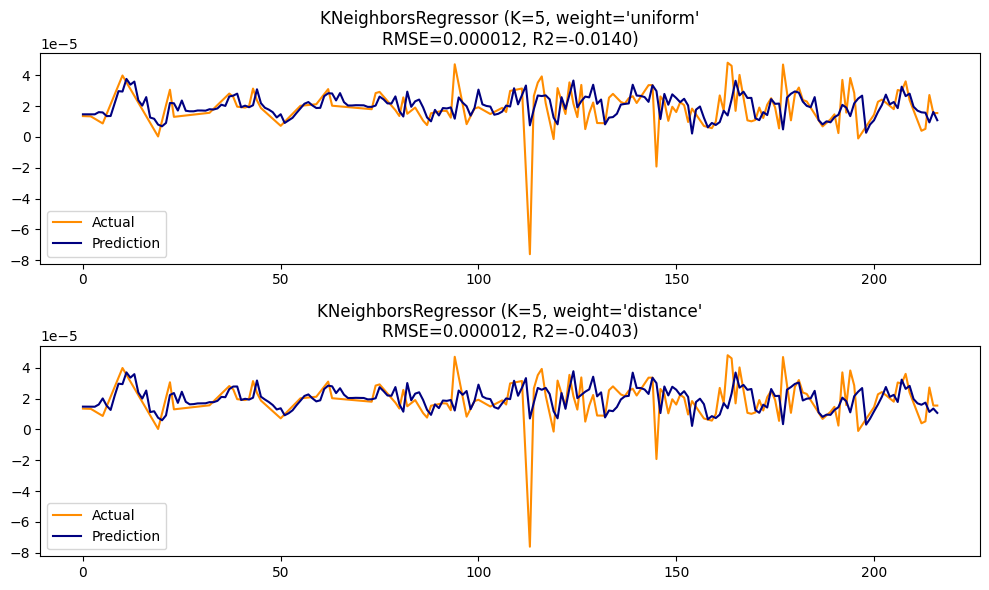

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = supervised[['NO2(t-4)', 'NO2(t-3)', 'NO2(t-2)', 'NO2(t-1)']]
y = supervised['NO2(t)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

n_neighbors = 5

plt.figure(figsize=(10, 6))

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    plt.subplot(2, 1, i + 1)
    plt.plot(range(len(y_test)), y_test, 'darkorange', label="Actual")
    plt.plot(range(len(y_pred)), y_pred, 'navy', label="Prediction")
    plt.title(f"KNeighborsRegressor (K={n_neighbors}, weight='{weights}'\nRMSE={rmse:.6f}, R2={r2:.4f})")
    plt.legend()
    plt.tight_layout()

plt.show()